# Proyek Klasifikasi Gambar: [Cards Image Dataset]
- **Nama:** [Ryan Rachmad Hidayat]
- **Email:** [ryan.rachmad.works@gmail.com]
- **ID Dicoding:** [ryan_rachmad_hidayat]

## Import Semua Packages/Library yang Digunakan

In [1]:
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,  # Nonaktifkan output
            stderr=subprocess.DEVNULL
        )
        print("Done")
    except subprocess.CalledProcessError:
        print("Gagal install:", package)

# Install googletrans versi yang stabil
install_package("tensorflowjs")

Done


In [2]:
# Import system libraries
import os
import itertools
from PIL import Image  # pillow

# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Input, Flatten, Concatenate

sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from collections import Counter
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
import tensorflowjs as tfjs
from sklearn.utils import shuffle
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5
warnings.simplefilter("ignore")

print(tfjs.__version__) # Cek versi dari Tensorflow.js
print(tf.__version__) # Cek versi dari Tensorflow

4.22.0
2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unzip File Dataset

import zipfile

test_local_zip = '/content/drive/MyDrive/archive.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('./')

### Data Preprocessing

#### Split Dataset

In [5]:
train_data_dir = '/content/Animals'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis=1)

# Load test data
test_data_dir = '/content/Animals'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate test data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

test_df = pd.concat([Fseries, Lseries], axis=1)

Found 3000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


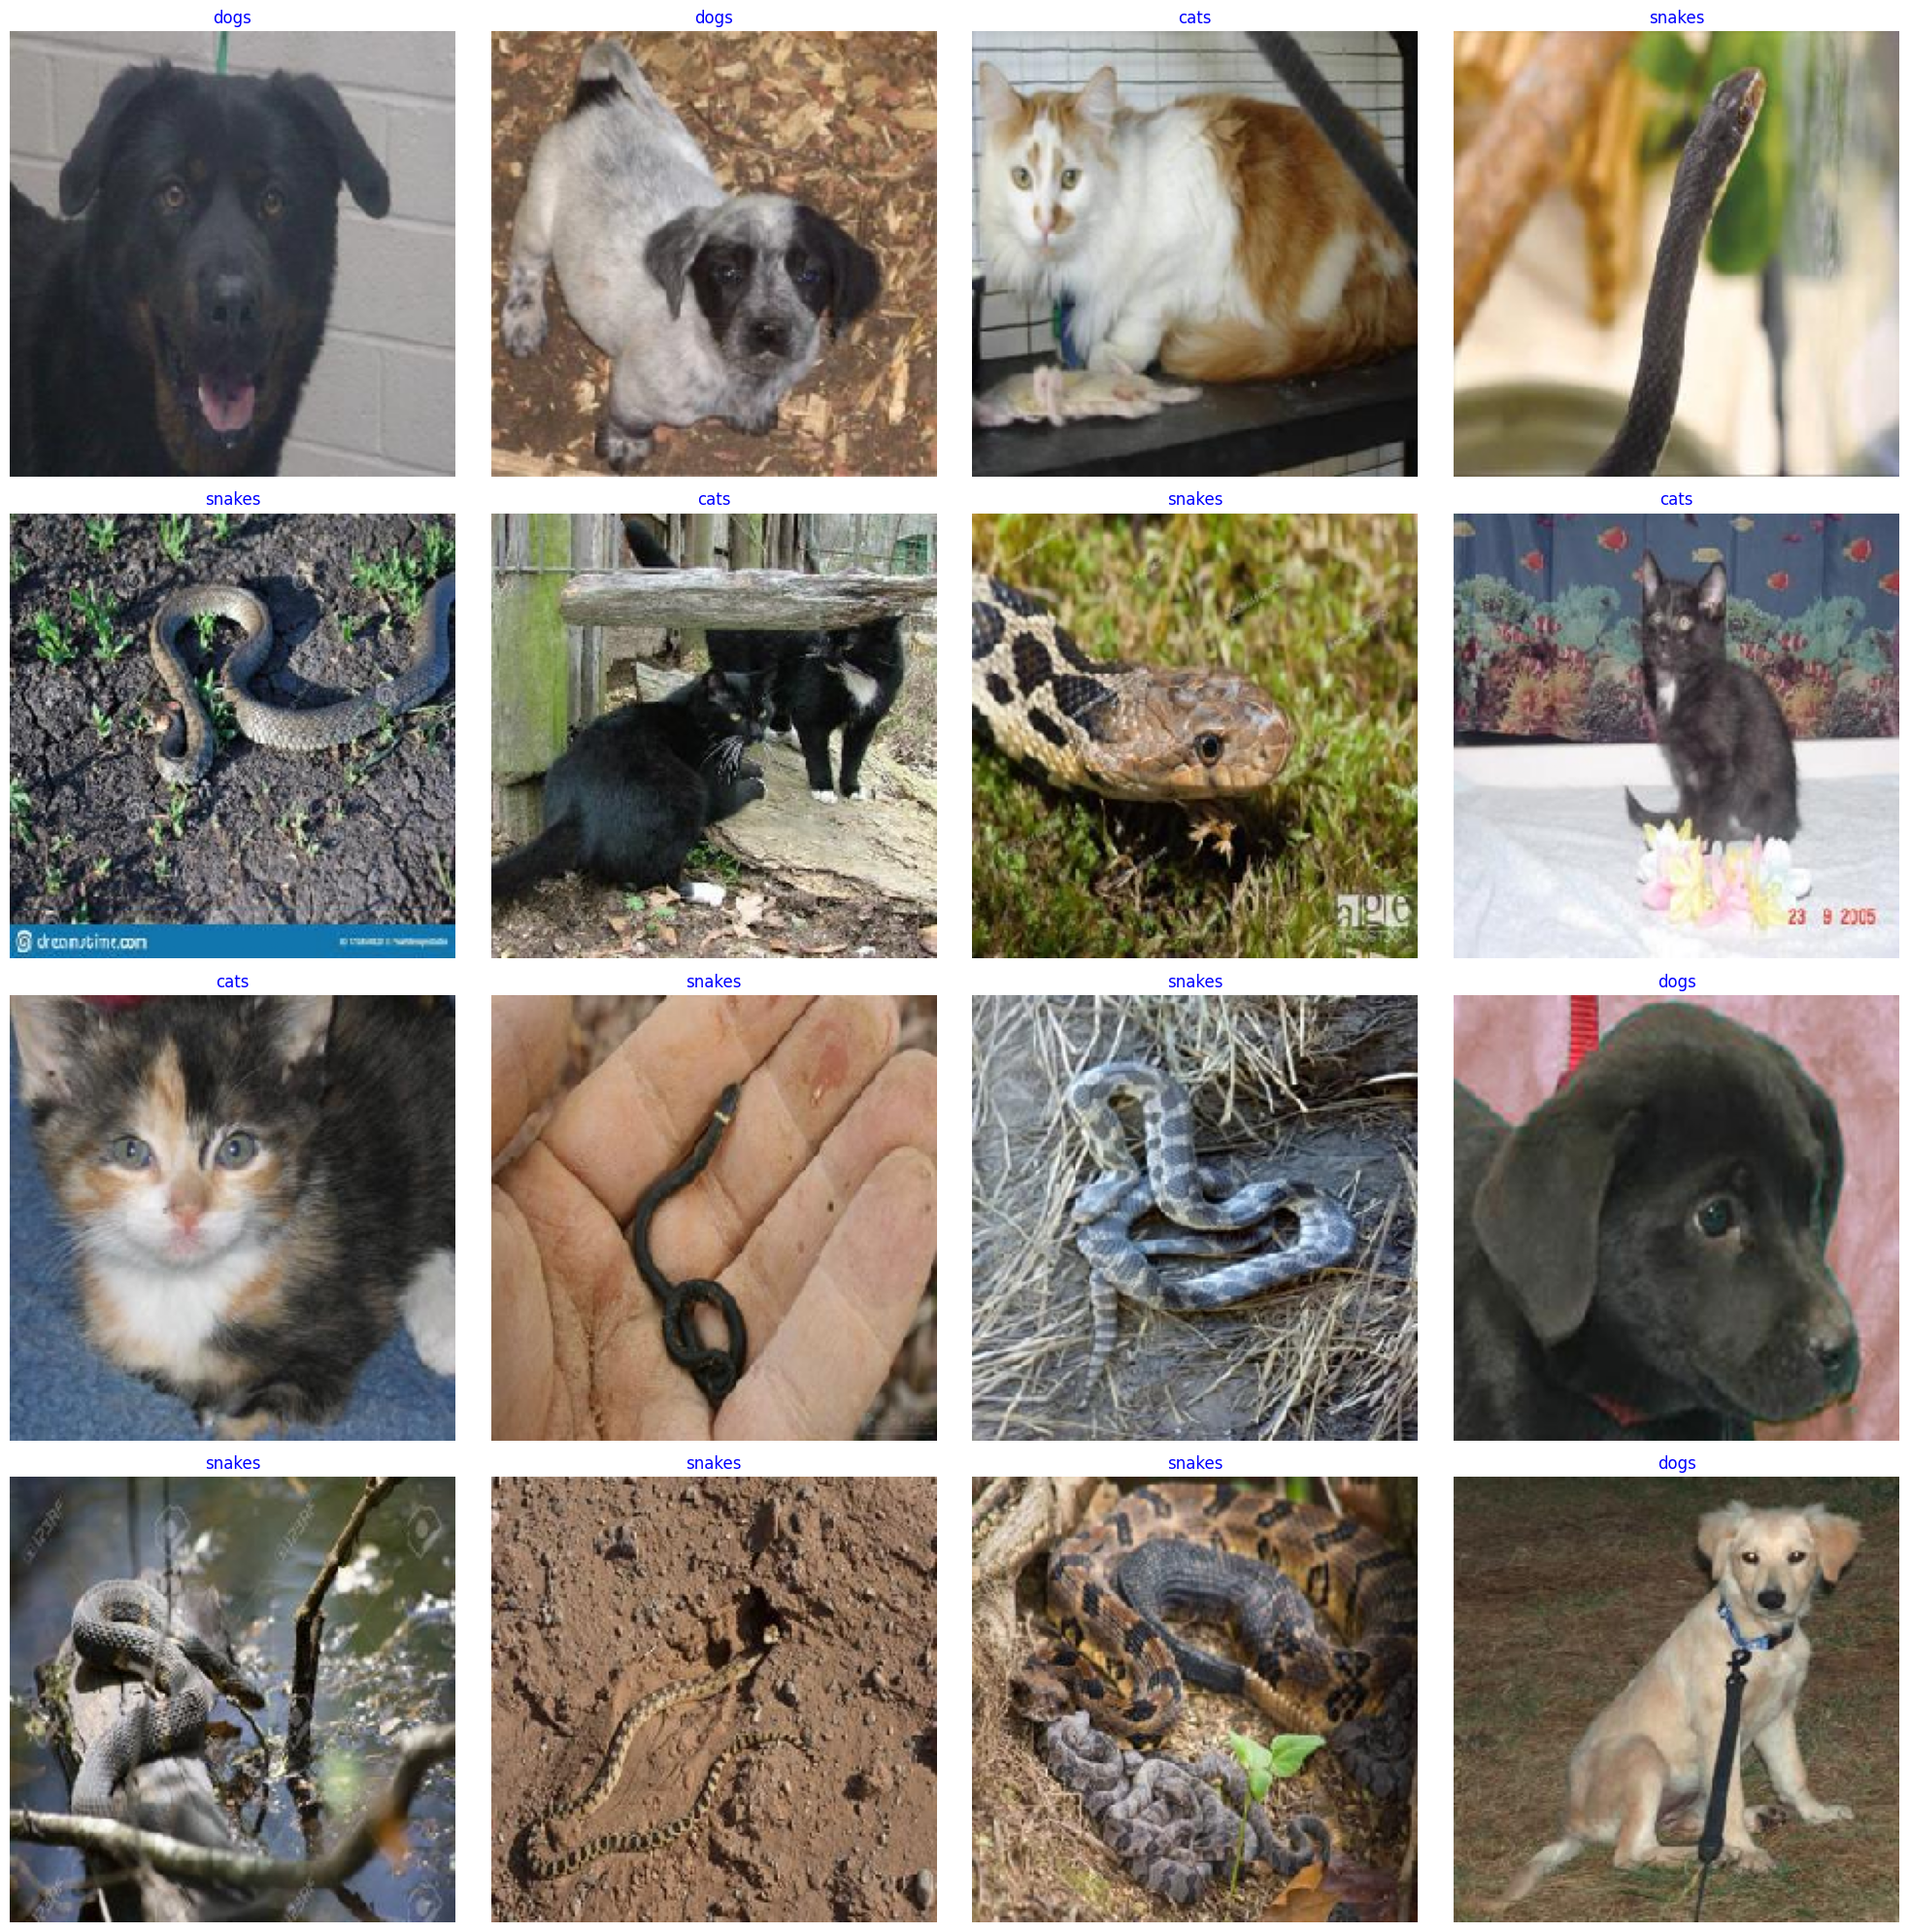

In [6]:
# Split the test data into validation and test sets
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

# Cropped image size and batch size
batch_size = 16
img_size = (224, 224)

# Create ImageDataGenerators for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

# Check the number of classes
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes)

# Display some images with labels
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Modelling

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.95:
                print("\nReached 95% training accuracy and 95% validation accuracy, so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [8]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = keras.models.Sequential([
    keras.layers.Rescaling(1./255, input_shape=[224, 224, 3]),  # Normalization
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Ensure the output size matches the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_gen, epochs=100, validation_data=valid_gen, shuffle=False, callbacks=callbacks)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.5001 - loss: 1.1677 - val_accuracy: 0.6453 - val_loss: 0.7613
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6343 - loss: 0.7548 - val_accuracy: 0.7260 - val_loss: 0.5886
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7048 - loss: 0.6364 - val_accuracy: 0.7687 - val_loss: 0.5372
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7504 - loss: 0.5652 - val_accuracy: 0.8420 - val_loss: 0.3937
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7953 - loss: 0.4617 - val_accuracy: 0.8327 - val_loss: 0.4092
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8270 - loss: 0.4080 - val_accuracy: 0.8633 - val_loss: 0.3406
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8734 - loss: 0.3198 - val_accuracy: 0.9307 - val_loss: 0.2151
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9198 - loss: 0.2244 -

## Evaluasi dan Visualisasi

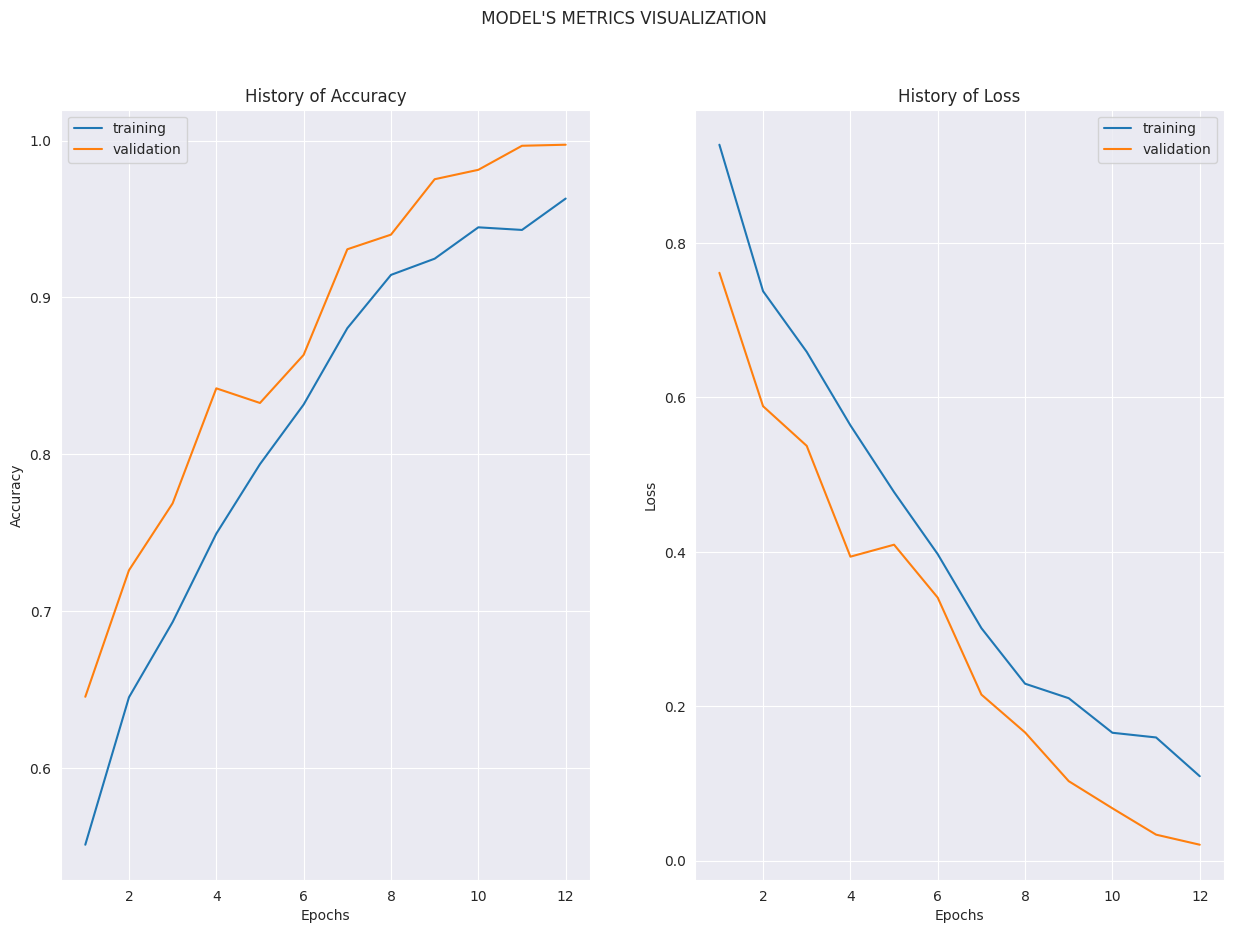

In [10]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [11]:
predictions = model.predict(test_gen)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_gen.classes

print(classification_report(true_labels, predicted_labels))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       510
           1       1.00      0.99      0.99       482
           2       1.00      1.00      1.00       508

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



## Konversi Model

### Model Keras H5

In [12]:
# Menyimpan model dalam format .keras
model.save('Animal_Image_Classification.h5')

In [13]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/Animal_Image_Classification'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'Animal_Image_Classification.h5')
model.save(model_path)

In [14]:
import keras.saving

# Menyimpan model dalam format .keras
keras.saving.save_model(model, 'Animal_Image_Classification.keras')

In [15]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/Animal_Image_Classification/'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'Animal_Image_Classification.keras')
model.save(model_path)

### Model TensorFlow.js

In [16]:
!tensorflowjs_converter --input_format keras \
                       /content/Animal_Image_Classification.h5 \
                       /content/Model_TFJS

2025-06-21 04:39:21.327338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750480761.347949   30293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750480761.354044   30293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [17]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_TFJS'
output_path = './drive/MyDrive/Animal_Image_Classification/Model_TFJS'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Animal_Image_Classification/Model_TFJS.zip


### Model PB

In [18]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('/content/Animal_Image_Classification.h5')

# Convert and save the model to TensorFlow.js format
path = ('/content/Model_PB')
tf.saved_model.save(model,path)

In [19]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_PB'
output_path = './drive/MyDrive/Animal_Image_Classification/Model_PB'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Animal_Image_Classification/Model_PB.zip


### Model TF-Lite

In [20]:
# Load model Keras
model = tf.keras.models.load_model('Animal_Image_Classification.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan sebagai file .tflite
with open('/content/Animal_Image_Classification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

Saved artifact at '/tmp/tmp4j1qlhfx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138261061319952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261061319376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261061318800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261061320528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971389200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971390928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971390736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971391696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971390544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138260971393040: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil di

In [24]:
import shutil

# Path ke file .tflite
file_path = '/content/Animal_Image_Classification.tflite'
zip_path = '/content/Animal_Image_Classification_tflite'

# Buat zip
zip_file = shutil.make_archive(zip_path, 'zip', root_dir='/content', base_dir='Animal_Image_Classification.tflite')

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/Animal_Image_Classification_tflite.zip


In [25]:
from google.colab import files

# Kumpulkan semua file ke dalam ZIP
shutil.make_archive('exported_files', 'zip', './drive/MyDrive/Animal_Image_Classification')

# Unduh ZIP-nya
files.download('exported_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
files.download('/content/Animal_Image_Classification_tflite.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>